### Import the dataset (from 24th April 2022 to 17 May 2022) 

In [3]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
plt.rcParams['figure.figsize'] = (14, 7)
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv('curved_labelled_data.csv')
df[['time']] = df[['time']].apply(pd.to_datetime)
df.rename(columns = {'Unnamed: 0':'x_column' }, inplace = True)

### Plotting the dataset 

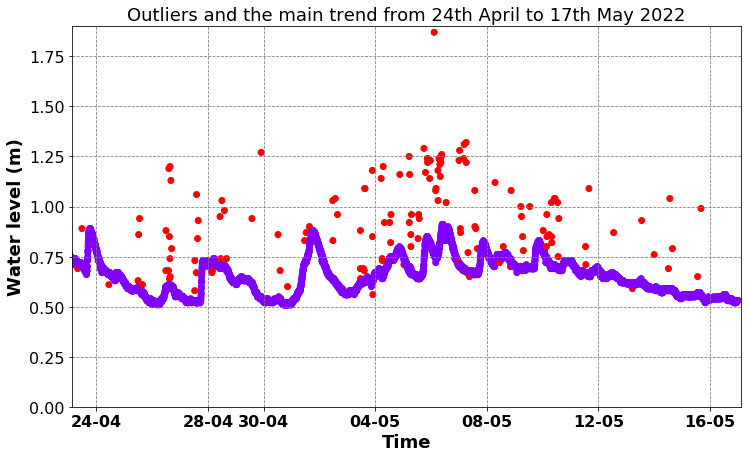

In [6]:
plt.rcParams['figure.figsize'] = (12, 7)
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('white')
ax.scatter(df['time'],df['height'], c= df['data_label'], cmap='rainbow')
ax.grid(color = 'gray', linestyle = '--', linewidth = 0.8)
ax.set_title('Outliers and the main trend from 24th April to 17th May 2022', fontsize=18)
ax.set_xlabel('Time', fontsize=18, weight = 'bold')
ax.set_ylabel('Water level (m)', fontsize=18, weight = 'bold')
ax.set_xlim(['2022-04-24 00:00:00'],['2022-05-17 23:59:59'])
ax.set_ylim(0, 1.9)
ax.set_xticklabels(df['time'], fontsize=16, weight='bold')
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x',which='major', labelsize=16)

## Define the date format
date_form = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(date_form)
ax.set(facecolor = "white")

plt.savefig('sample_photo_curved.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()

### Kernel density estimation
- To establish the unknown probability distribution of the water level data produced by the sensor. This knowledge can be   reveraged in getting of data points regarded to as anomalies. 

### The histogram
- To Determine the distribution of data samples. 

1.87

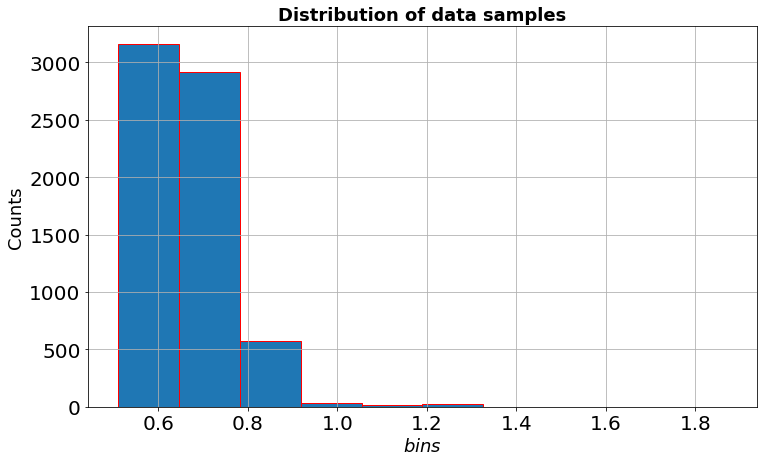

In [7]:
data_samples = np.array(df['height'])
plt.rcParams['figure.figsize'] = (12, 7)
plt.hist(data_samples, 10, edgecolor = 'Red');
plt.title('Distribution of data samples',fontsize=18,weight = 'bold')
plt.xlabel(r'$bins$', fontsize=18)
plt.ylabel('Counts', fontsize=18)
plt.tick_params(axis='both',labelsize=20,)
plt.tick_params(axis = 'x', labelsize = 20,)
#plt.yscale("log")
plt.grid(True)
max(data_samples)

### Kernel density estimation method (Sklearn)
- fitting a known distribution to the data 
- kernel density from sklearn

In [8]:
#KernelDensity from scikit learn
from sklearn.neighbors import KernelDensity
import numpy as np

### Silverman's Rule of thumb (NRD0)
- if the data is unimodal but not symmetric

In [9]:
# bandwidth calculation
#calculate interquartile range 
q3, q1 = np.percentile(data_samples, [75 ,25])
iqr = q3 - q1
# calculate the standard deviation
strd = np.std(data_samples)
# calculate the bandwidth
h_band = 0.9 * min(iqr, strd) * (len(data_samples) ** -0.2) 
h_band

0.015987927516236893

### Silverman's Rule of thumb - Long tailed

In [10]:
h_band2 = 0.79 * iqr * (len(data_samples) ** -0.2)
h_band2

0.019322867064504288

In [11]:
kde = KernelDensity(kernel="gaussian", bandwidth = h_band).fit(data_samples.reshape(-1, 1))

In [12]:
data_sample_plot = np.linspace(np.min(data_samples),np.max(data_samples),100)
#log density
log_density = kde.score_samples(data_sample_plot.reshape(-1, 1))

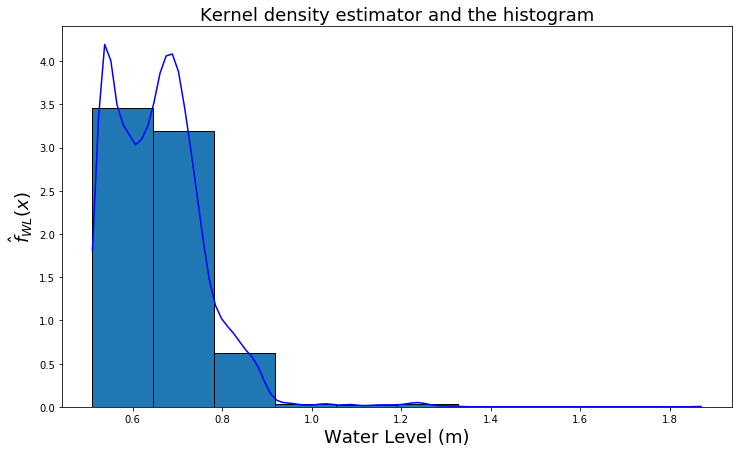

In [13]:
plt.hist(data_samples, 10, edgecolor = 'black', density=True);
plt.title('Kernel density estimator and the histogram', fontsize=18)
plt.xlabel('Water Level (m)', fontsize=18)
plt.ylabel(r'$\hat{f}_{WL}(x)$', fontsize=18)
plt.plot(data_sample_plot, np.exp(log_density), color = 'b')

### Anomaly detection using the suprise factor

In [14]:
surprise_threshold = 0
length = np.array(df.height)

### first trial 

In [15]:
# clusters_dic = {}

# split_list = np.arange(1,261,1)
# for i in split_list:
#     water_arrays = np.array_split(length, i)
#     surprise_list = []
#     clusters =[]
#     for element in water_arrays:
#         kde = KernelDensity(kernel="gaussian", bandwidth = h_band).fit(element.reshape(-1, 1))
#         surprise = -kde.score_samples(element.reshape(-1, 1))
#         surprise_list.append(surprise.tolist())
#     sup_tup = tuple(surprise_list)
#     surprise_concat = np.concatenate(sup_tup).tolist()
#     #print(len(surprise_concat))
#     for ii in surprise_concat:
#         if ii < surprise_threshold:
#             cluster = 0
#         else:
#             cluster = 1
#         clusters.append(cluster)
#     clusters_dic[str(i)] = clusters
#     #print(clusters_dic, '\n\n\n\n\n\n\n\n\n')    

### second trial 

In [19]:
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score 
data_labels = list(df.data_label)
len(data_labels)

6712

In [24]:
data_win = list(df.height)
window_size_list = np.arange(5,300,5,dtype=int)

In [25]:
#window_size_list = np.arange(10,1500,10,dtype=int)
clusters_dic = {}

for i in window_size_list:
    win_list = []
    for indx in range(0,len(data_win)-i,i):
        data_int = data_win[indx:indx+i]
        win_list.append(data_int)
    win_list = np.array(win_list)
    surprise_list = []
    clusters =[]
    for element in win_list:
        kde = KernelDensity(kernel="gaussian", bandwidth = h_band).fit(element.reshape(-1, 1))
        surprise = -kde.score_samples(element.reshape(-1, 1))
        surprise_list.append(surprise.tolist())
    sup_tup = tuple(surprise_list)
    surprise_concat = np.concatenate(sup_tup).tolist()
    #print(len(surprise_concat))
    for ii in surprise_concat:
        if ii < surprise_threshold:
            cluster = 0
        else:
            cluster = 1
        clusters.append(cluster)
    clusters_dic[str(i)] = clusters
    #print(clusters_dic, '\n\n\n\n\n\n\n\n\n') 

In [30]:
precision_scores = []
accuracy_scores = []
recall_scores = []
f1_scores = []
for key in clusters_dic:
    kde_labels = clusters_dic[key]
    data_precision_score = precision_score(data_labels[:len(kde_labels)],kde_labels)
    data_accuracy_score = accuracy_score(data_labels[:len(kde_labels)],kde_labels)
    data_f1_score = f1_score(data_labels[:len(kde_labels)],kde_labels)
    data_recall_score = recall_score(data_labels[:len(kde_labels)],kde_labels)
    
    precision_scores.append(data_precision_score)
    accuracy_scores.append(data_accuracy_score)
    recall_scores.append(data_recall_score)
    f1_scores.append(data_f1_score)

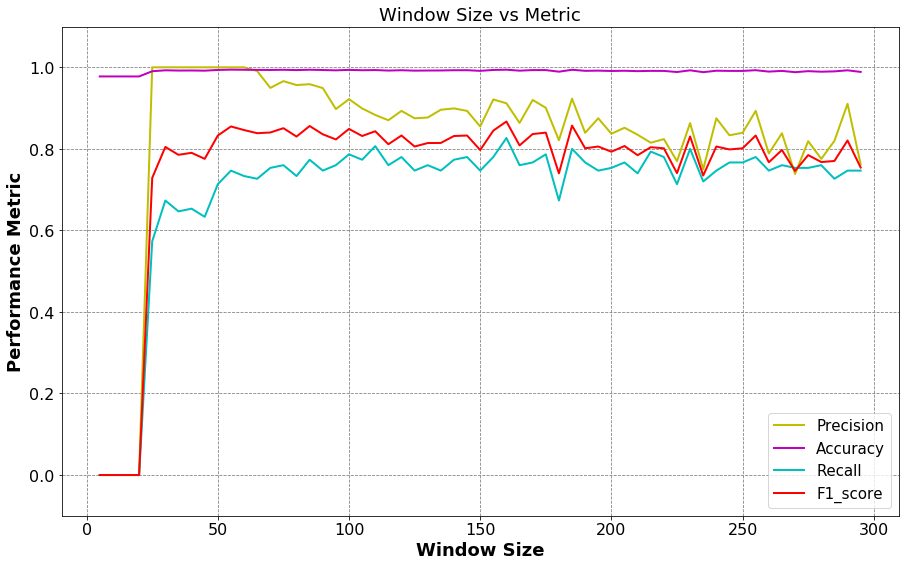

In [31]:
plt.rcParams['figure.figsize'] = (15, 9)
fig, ax = plt.subplots(1,1)
fig.patch.set_facecolor('white')

Precision = ax.plot(window_size_list,precision_scores, color='y', linewidth=2)
Accuracy = ax.plot(window_size_list,accuracy_scores, color='m', linewidth=2)
Recall = ax.plot(window_size_list,recall_scores, color='c', linewidth=2)
F1_scores = ax.plot(window_size_list,f1_scores, color='r', linewidth=2)

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.8)
ax.set_title('Window Size vs Metric', fontsize=18)
ax.set_xlabel('Window Size', fontsize=18, weight = 'bold')
ax.set_ylabel('Performance Metric', fontsize=18, weight = 'bold')
ax.set_ylim(-.1, 1.1)
ax.tick_params(axis='y', labelsize=16)
ax.tick_params(axis='x',which='major', labelsize=16)

## Define the date format
date_form = DateFormatter("%d-%m")
ax.legend(["Precision", "Accuracy", "Recall", "F1_score"], loc ="lower right", fancybox=True,facecolor='#FFFFFF',prop={'size': 15,  'style': 'normal'})
ax.set(facecolor = "white")

plt.savefig('window_iteration.png', dpi=450, orientation='portrait', bbox_inches='tight', facecolor='w',edgecolor='b',)
plt.show()

In [34]:
k = np.argmax(recall_scores)
q = window_size_list[k]
q

160